Desired cell size: 500.000 km. Selected resolution n = 9.
Using n = 9: Avg cell edge ≈ 494.495 km, Avg cell area ≈ 628158.217 km^2.
Cell counts: 800 hexagons, 12 pentagons (ideally 12 pentagons).


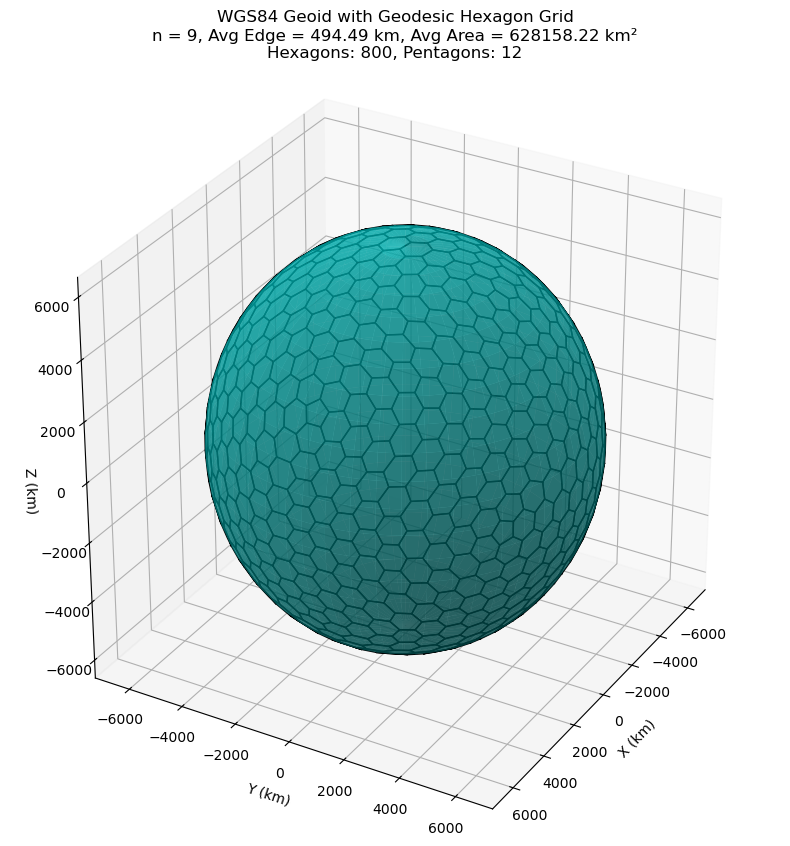

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, acos, atan2, sqrt, pi

R_mean = 6371  # Mean Earth radius in km

def barycentricCoords(p):
    x, y = p
    l3 = (2 * y) / sqrt(3)
    l2 = x + 0.5*(1 - l3)
    l1 = 1 - l2 - l3
    return l1, l2, l3

def slerp(p0, p1, t):
    p0 = np.array(p0)
    p1 = np.array(p1)
    p0 = p0 / np.linalg.norm(p0)
    p1 = p1 / np.linalg.norm(p1)
    dot = np.clip(np.dot(p0, p1), -1.0, 1.0)
    theta = acos(dot)
    if abs(theta) < 1e-6:
        return p0
    return (sin((1-t)*theta)*p0 + sin(t*theta)*p1) / sin(theta)

def mapGridpoint2Sphere(p, s1, s2, s3):
    l1, l2, l3 = barycentricCoords(p)
    if abs(l3 - 1) < 1e-10:
        return s3
    l2s = l2 / (l1 + l2) if (l1+l2) != 0 else 0
    p12 = slerp(s1, s2, l2s)
    return slerp(p12, s3, l3)

def spherical_to_geodetic(p_unit, a, b):
    x, y, z = p_unit
    lat = np.arcsin(z / np.linalg.norm(p_unit))
    lon = np.arctan2(y, x)
    X = a * cos(lat) * cos(lon)
    Y = a * cos(lat) * sin(lon)
    Z = b * sin(lat)
    return np.array([X, Y, Z])

def generate_icosahedron():
    phi = (1 + sqrt(5)) / 2
    pts = []
    pts.extend([np.array([-1,  phi, 0]),
                np.array([ 1,  phi, 0]),
                np.array([-1, -phi, 0]),
                np.array([ 1, -phi, 0])])
    pts.extend([np.array([0, -1,  phi]),
                np.array([0,  1,  phi]),
                np.array([0, -1, -phi]),
                np.array([0,  1, -phi])])
    pts.extend([np.array([ phi, 0, -1]),
                np.array([ phi, 0,  1]),
                np.array([-phi, 0, -1]),
                np.array([-phi, 0,  1])])
    vertices = [p/np.linalg.norm(p) for p in pts]
    
    faces = [
        (0, 11, 5),
        (0, 5, 1),
        (0, 1, 7),
        (0, 7, 10),
        (0, 10, 11),
        (1, 5, 9),
        (5, 11, 4),
        (11, 10, 2),
        (10, 7, 6),
        (7, 1, 8),
        (3, 9, 4),
        (3, 4, 2),
        (3, 2, 6),
        (3, 6, 8),
        (3, 8, 9),
        (4, 9, 5),
        (2, 4, 11),
        (6, 2, 10),
        (8, 6, 7),
        (9, 8, 1),
    ]
    return vertices, faces

def generate_triangle_grid(n_res):
    # Define vertices of the reference triangle
    A = np.array([-0.5, 0])
    B = np.array([0.5, 0])
    C = np.array([0, sqrt(3)/2])
    # Create indices for a (n_res+1) x (n_res+1) grid
    I, J = np.indices((n_res+1, n_res+1))
    mask = (I + J <= n_res)
    I = I[mask]
    J = J[mask]
    u = I / n_res
    v = J / n_res
    w = 1 - u - v
    # Compute points using broadcasting
    pts = u[:, None]*A + v[:, None]*B + w[:, None]*C
    pts = pts.tolist()
    keys = list(zip(I.tolist(), J.tolist()))
    # Build dictionary mapping key -> point (as np.array)
    pts_dict = {k: np.array(pt) for k, pt in zip(keys, pts)}
    return pts_dict, keys

def add_global_vertex(p, global_vertices, tol=1e-6):
    for i, q in enumerate(global_vertices):
        if np.linalg.norm(p - q) < tol:
            return i
    global_vertices.append(p)
    return len(global_vertices)-1

def build_global_triangulation(n_res):
    global_vertices = []
    global_triangles = []
    ico_vertices, ico_faces = generate_icosahedron()
    grid2D, grid_keys = generate_triangle_grid(n_res)
    
    for face in ico_faces:
        s1, s2, s3 = ico_vertices[face[0]], ico_vertices[face[1]], ico_vertices[face[2]]
        local_index = {}
        for key in grid_keys:
            p = mapGridpoint2Sphere(grid2D[key], s1, s2, s3)
            gi = add_global_vertex(p, global_vertices)
            local_index[key] = gi
        for i in range(n_res):
            for j in range(n_res - i):
                if (i, j) in local_index and (i+1, j) in local_index and (i, j+1) in local_index:
                    t1 = (local_index[(i, j)], local_index[(i+1, j)], local_index[(i, j+1)])
                    global_triangles.append(t1)
                if (i+1, j) in local_index and (i+1, j+1) in local_index and (i, j+1) in local_index:
                    t2 = (local_index[(i+1, j)], local_index[(i+1, j+1)], local_index[(i, j+1)])
                    global_triangles.append(t2)
    return global_vertices, global_triangles

def triangle_centroid(tri, vertices):
    pts = [vertices[i] for i in tri]
    c = np.mean(pts, axis=0)
    return c / np.linalg.norm(c)

def build_dual_cells(vertices, triangles):
    vertex_to_tri = {i: [] for i in range(len(vertices))}
    for tri in triangles:
        c = triangle_centroid(tri, vertices)
        for v in tri:
            vertex_to_tri[v].append(c)
    
    dual_cells = []
    for v, centroids in vertex_to_tri.items():
        if len(centroids) < 3:
            continue
        center = vertices[v]
        up = np.array([0, 0, 1])
        if abs(np.dot(center, up)) > 0.99:
            up = np.array([0, 1, 0])
        t1 = up - np.dot(up, center) * center
        t1 = t1 / np.linalg.norm(t1)
        t2 = np.cross(center, t1)
        angles = []
        for c in centroids:
            proj = c - np.dot(c, center) * center
            angle = atan2(np.dot(proj, t2), np.dot(proj, t1))
            angles.append(angle)
        sorted_centroids = [c for _, c in sorted(zip(angles, centroids), key=lambda x: x[0])]
        dual_cells.append({
            "center_index": v,
            "cell_vertices": sorted_centroids,
            "n_edges": len(sorted_centroids)
        })
    return dual_cells

def compute_cell_metrics(dual_cells, R_mean=R_mean):
    edge_lengths = []
    areas = []
    count_hex = 0
    count_pent = 0

    for cell in dual_cells:
        verts = cell["cell_vertices"]
        n = len(verts)
        if n < 3:
            continue
        verts_arr = np.array(verts)
        # Vectorized computation of edge distances:
        v1 = verts_arr
        v2 = np.roll(verts_arr, -1, axis=0)
        dots = np.clip(np.sum(v1*v2, axis=1), -1.0, 1.0)
        dists = R_mean * np.arccos(dots)
        avg_edge = np.mean(dists)
        edge_lengths.append(avg_edge)
        
        # Vectorized computation of interior angles:
        v_prev = np.roll(verts_arr, 1, axis=0)
        v_next = np.roll(verts_arr, -1, axis=0)
        n1 = np.cross(verts_arr, v_prev)
        n2 = np.cross(verts_arr, v_next)
        n1_norm = n1 / np.linalg.norm(n1, axis=1, keepdims=True)
        n2_norm = n2 / np.linalg.norm(n2, axis=1, keepdims=True)
        cos_angles = np.clip(np.sum(n1_norm * n2_norm, axis=1), -1.0, 1.0)
        angles = np.arccos(cos_angles)
        spherical_excess = np.sum(angles) - (n - 2) * pi
        area = spherical_excess * (R_mean**2)
        areas.append(area)
        
        if n == 6:
            count_hex += 1
        elif n == 5:
            count_pent += 1

    avg_edge_overall = np.mean(edge_lengths) if edge_lengths else None
    avg_area_overall = np.mean(areas) if areas else None
    return avg_edge_overall, avg_area_overall, count_hex, count_pent

def main(mode="n", value=10, size_flag=None):
    # For geoid display
    a_display = 6378.137
    b_display = 6356.752

    if mode == "n":
        n_res = int(value)
        vertices, triangles = build_global_triangulation(n_res)
        dual_cells = build_dual_cells(vertices, triangles)
        avg_edge, avg_area, count_hex, count_pent = compute_cell_metrics(dual_cells)
    elif mode == "cellsize":
        desired_size = float(value)
        previous = None
        for n in range(2, 101):
            vertices, triangles = build_global_triangulation(n)
            dual_cells = build_dual_cells(vertices, triangles)
            avg_edge, avg_area, count_hex, count_pent = compute_cell_metrics(dual_cells)
            if avg_edge is None:
                continue
            if desired_size > avg_edge:
                if size_flag == "ceil":
                    n_res = previous[0] if previous is not None else n
                    avg_edge, avg_area, count_hex, count_pent = previous[1:]
                elif size_flag == "floor":
                    n_res = n
                break
            previous = (n, avg_edge, avg_area, count_hex, count_pent)
        else:
            n_res, avg_edge, avg_area, count_hex, count_pent = previous
        print(f"Desired cell size: {desired_size:.3f} km. Selected resolution n = {n_res}.")
    else:
        raise ValueError("Mode must be either 'n' or 'cellsize'.")

    print(f"Using n = {n_res}: Avg cell edge ≈ {avg_edge:.3f} km, Avg cell area ≈ {avg_area:.3f} km^2.")
    print(f"Cell counts: {count_hex} hexagons, {count_pent} pentagons (ideally 12 pentagons).")
    
    # Build geoid surface for visualization (WGS84 ellipsoid)
    u_vals, v_vals = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]
    X = a_display * np.cos(u_vals) * np.sin(v_vals)
    Y = a_display * np.sin(u_vals) * np.sin(v_vals)
    Z = b_display * np.cos(v_vals)
    
    # Rebuild dual cells for visualization
    vertices, triangles = build_global_triangulation(n_res)
    dual_cells = build_dual_cells(vertices, triangles)
    for cell in dual_cells:
        cell_ellipsoid = []
        for v in cell["cell_vertices"]:
            cell_ellipsoid.append(spherical_to_geodetic(v, a_display, b_display))
        cell["cell_vertices_ellipsoid"] = cell_ellipsoid

    elev = 30
    azim = 30
    theta = np.radians(90 - elev)
    phi = np.radians(azim)
    view_vector = np.array([sin(theta)*cos(phi),
                            sin(theta)*sin(phi),
                            cos(theta)])
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, color='c', alpha=0.6, rstride=4, cstride=4, edgecolor='none')
    
    for cell in dual_cells:
        pts = np.array(cell["cell_vertices_ellipsoid"])
        if pts.shape[0] < 3:
            continue
        cell_center = np.mean(pts, axis=0)
        cell_center_norm = cell_center / np.linalg.norm(cell_center)
        if np.dot(cell_center_norm, view_vector) > 0:
            poly = np.vstack([pts, pts[0]])
            ax.plot(poly[:,0], poly[:,1], poly[:,2], 'k-', linewidth=1.0)
    
    info_str = f"n = {n_res}, Avg Edge = {avg_edge:.2f} km, Avg Area = {avg_area:.2f} km²\nHexagons: {count_hex}, Pentagons: {count_pent}"
    title_str = f"WGS84 Geoid with Geodesic Hexagon Grid\n{info_str}"
    ax.set_title(title_str)
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Y (km)")
    ax.set_zlabel("Z (km)")
    ax.set_box_aspect([a_display, a_display, b_display])
    ax.view_init(elev=elev, azim=azim)
    
    plt.show()

if __name__ == '__main__':
    # Mode 1: Direct resolution input:
    # main(mode="n", value=40)
    
    # Mode 2: Desired cell size input (in km) with flag "ceil" or "floor":
    main(mode="cellsize", value=500, size_flag="floor")


In [1]:
import numpy as np
import pyvista as pv
from pyvista import examples
from math import sin, cos, acos, atan2, sqrt, pi

R_mean = 6371  # mean Earth radius in km

##################################
# Helper functions (spherical math)
##################################
def barycentricCoords(p):
    x, y = p
    l3 = (2 * y) / sqrt(3)
    l2 = x + 0.5 * (1 - l3)
    l1 = 1 - l2 - l3
    return l1, l2, l3

def slerp(p0, p1, t):
    p0 = np.array(p0)
    p1 = np.array(p1)
    p0 = p0 / np.linalg.norm(p0)
    p1 = p1 / np.linalg.norm(p1)
    dot = np.clip(np.dot(p0, p1), -1.0, 1.0)
    theta = acos(dot)
    if abs(theta) < 1e-6:
        return p0
    return (sin((1-t)*theta) * p0 + sin(t*theta) * p1) / sin(theta)

def mapGridpoint2Sphere(p, s1, s2, s3):
    l1, l2, l3 = barycentricCoords(p)
    if abs(l3 - 1) < 1e-10:
        return s3
    l2s = l2 / (l1 + l2) if (l1+l2) != 0 else 0
    p12 = slerp(s1, s2, l2s)
    return slerp(p12, s3, l3)

def spherical_to_geodetic(p_unit, a, b):
    x, y, z = p_unit
    lat = np.arcsin(z / np.linalg.norm(p_unit))
    lon = np.arctan2(y, x)
    X = a * cos(lat) * cos(lon)
    Y = a * cos(lat) * sin(lon)
    Z = b * sin(lat)
    return np.array([X, Y, Z])

##################################
# Icosahedron subdivision and dual mesh functions
##################################
def generate_icosahedron():
    phi = (1 + sqrt(5)) / 2
    pts = []
    pts.extend([np.array([-1,  phi, 0]),
                np.array([ 1,  phi, 0]),
                np.array([-1, -phi, 0]),
                np.array([ 1, -phi, 0])])
    pts.extend([np.array([0, -1,  phi]),
                np.array([0,  1,  phi]),
                np.array([0, -1, -phi]),
                np.array([0,  1, -phi])])
    pts.extend([np.array([ phi, 0, -1]),
                np.array([ phi, 0,  1]),
                np.array([-phi, 0, -1]),
                np.array([-phi, 0,  1])])
    vertices = [p / np.linalg.norm(p) for p in pts]
    faces = [
        (0, 11, 5),
        (0, 5, 1),
        (0, 1, 7),
        (0, 7, 10),
        (0, 10, 11),
        (1, 5, 9),
        (5, 11, 4),
        (11, 10, 2),
        (10, 7, 6),
        (7, 1, 8),
        (3, 9, 4),
        (3, 4, 2),
        (3, 2, 6),
        (3, 6, 8),
        (3, 8, 9),
        (4, 9, 5),
        (2, 4, 11),
        (6, 2, 10),
        (8, 6, 7),
        (9, 8, 1),
    ]
    return vertices, faces

def generate_triangle_grid(n_res):
    A = np.array([-0.5, 0])
    B = np.array([0.5, 0])
    C = np.array([0, sqrt(3)/2])
    pts = {}
    keys = []
    for i in range(n_res+1):
        for j in range(n_res+1 - i):
            u_val = i / n_res
            v_val = j / n_res
            w_val = 1 - u_val - v_val
            pts[(i, j)] = u_val*A + v_val*B + w_val*C
            keys.append((i, j))
    return pts, keys

def add_global_vertex(p, global_vertices, tol=1e-6):
    for i, q in enumerate(global_vertices):
        if np.linalg.norm(p - q) < tol:
            return i
    global_vertices.append(p)
    return len(global_vertices)-1

def build_global_triangulation(n_res):
    global_vertices = []
    global_triangles = []
    ico_vertices, ico_faces = generate_icosahedron()
    grid2D, grid_keys = generate_triangle_grid(n_res)
    
    for face in ico_faces:
        s1, s2, s3 = ico_vertices[face[0]], ico_vertices[face[1]], ico_vertices[face[2]]
        local_index = {}
        for key in grid_keys:
            p = mapGridpoint2Sphere(grid2D[key], s1, s2, s3)
            gi = add_global_vertex(p, global_vertices)
            local_index[key] = gi
        for i in range(n_res):
            for j in range(n_res - i):
                if (i, j) in local_index and (i+1, j) in local_index and (i, j+1) in local_index:
                    t1 = (local_index[(i, j)], local_index[(i+1, j)], local_index[(i, j+1)])
                    global_triangles.append(t1)
                if (i+1, j) in local_index and (i+1, j+1) in local_index and (i, j+1) in local_index:
                    t2 = (local_index[(i+1, j)], local_index[(i+1, j+1)], local_index[(i, j+1)])
                    global_triangles.append(t2)
    return global_vertices, global_triangles

def triangle_centroid(tri, vertices):
    pts = [vertices[i] for i in tri]
    c = np.mean(pts, axis=0)
    return c / np.linalg.norm(c)

def build_dual_cells(vertices, triangles):
    vertex_to_tri = {i: [] for i in range(len(vertices))}
    for tri in triangles:
        c = triangle_centroid(tri, vertices)
        for v in tri:
            vertex_to_tri[v].append(c)
    
    dual_cells = []
    for v, centroids in vertex_to_tri.items():
        if len(centroids) < 3:
            continue
        center = vertices[v]
        up = np.array([0, 0, 1])
        if abs(np.dot(center, up)) > 0.99:
            up = np.array([0, 1, 0])
        t1 = up - np.dot(up, center) * center
        t1 = t1 / np.linalg.norm(t1)
        t2 = np.cross(center, t1)
        angles = []
        for c in centroids:
            proj = c - np.dot(c, center) * center
            angle = atan2(np.dot(proj, t2), np.dot(proj, t1))
            angles.append(angle)
        sorted_centroids = [c for _, c in sorted(zip(angles, centroids), key=lambda x: x[0])]
        dual_cells.append({
            "center_index": v,
            "cell_vertices": sorted_centroids,
            "n_edges": len(sorted_centroids)
        })
    return dual_cells

def compute_cell_metrics(dual_cells, R_mean=R_mean):
    edge_lengths = []
    areas = []
    count_hex = 0
    count_pent = 0

    for cell in dual_cells:
        verts = cell["cell_vertices"]
        n = len(verts)
        if n < 3:
            continue
        verts_arr = np.array(verts)
        v1 = verts_arr
        v2 = np.roll(verts_arr, -1, axis=0)
        dots = np.clip(np.sum(v1 * v2, axis=1), -1.0, 1.0)
        dists = R_mean * np.arccos(dots)
        avg_edge = np.mean(dists)
        edge_lengths.append(avg_edge)
        
        v_prev = np.roll(verts_arr, 1, axis=0)
        v_next = np.roll(verts_arr, -1, axis=0)
        n1 = np.cross(verts_arr, v_prev)
        n2 = np.cross(verts_arr, v_next)
        n1_norm = n1 / np.linalg.norm(n1, axis=1, keepdims=True)
        n2_norm = n2 / np.linalg.norm(n2, axis=1, keepdims=True)
        cos_angles = np.clip(np.sum(n1_norm * n2_norm, axis=1), -1.0, 1.0)
        angles = np.arccos(cos_angles)
        spherical_excess = np.sum(angles) - (n - 2) * pi
        area = spherical_excess * (R_mean**2)
        areas.append(area)
        
        if n == 6:
            count_hex += 1
        elif n == 5:
            count_pent += 1

    avg_edge_overall = np.mean(edge_lengths) if edge_lengths else None
    avg_area_overall = np.mean(areas) if areas else None
    return avg_edge_overall, avg_area_overall, count_hex, count_pent

##################################
# Visualization using PyVista
##################################
def main(mode="n", value=10, size_flag=None):
    # Use PyVista's Earth mesh and texture for background.
    earth_mesh = examples.planets.load_earth()
    earth_texture = examples.load_globe_texture()
    # For our projection, use these Earth parameters:
    a_disp = 1.01#6378.137/1000
    b_disp = 1.01#6356.752/1000

    if mode == "n":
        n_res = int(value)
        vertices, triangles = build_global_triangulation(n_res)
        dual_cells = build_dual_cells(vertices, triangles)
        avg_edge, avg_area, count_hex, count_pent = compute_cell_metrics(dual_cells)
    elif mode == "cellsize":
        desired_size = float(value)
        previous = None
        for n in range(2, 101):
            vertices, triangles = build_global_triangulation(n)
            dual_cells = build_dual_cells(vertices, triangles)
            avg_edge, avg_area, count_hex, count_pent = compute_cell_metrics(dual_cells)
            if avg_edge is None:
                continue
            if desired_size > avg_edge:
                if size_flag == "ceil":
                    n_res = previous[0] if previous is not None else n
                    avg_edge, avg_area, count_hex, count_pent = previous[1:]
                elif size_flag == "floor":
                    n_res = n
                break
            previous = (n, avg_edge, avg_area, count_hex, count_pent)
        else:
            n_res, avg_edge, avg_area, count_hex, count_pent = previous
        print(f"Desired cell size: {desired_size:.3f} km. Selected resolution n = {n_res}.")
    else:
        raise ValueError("Mode must be either 'n' or 'cellsize'.")

    print(f"Using n = {n_res}: Avg edge ≈ {avg_edge:.3f} km, Avg area ≈ {avg_area:.3f} km².")
    print(f"Cells: {count_hex} hexagons, {count_pent} pentagons (ideally 12 pentagons).")
    
    # Rebuild dual cells for overlay.
    vertices, triangles = build_global_triangulation(n_res)
    dual_cells = build_dual_cells(vertices, triangles)
    for cell in dual_cells:
        pts = []
        for v in cell["cell_vertices"]:
            pts.append(spherical_to_geodetic(v, a_disp, b_disp))
        cell["cell_vertices_ellipsoid"] = np.array(pts)
    
    # Create PyVista plotter and add Earth mesh.
    pl = pv.Plotter()
    image_path = examples.planets.download_stars_sky_background(load=False)
    pl.add_background_image(image_path)
    
    
    # For each dual cell, create a PolyData for filled polygon and extract its boundary edges.
    for cell in dual_cells:
        pts = cell["cell_vertices_ellipsoid"]
        if pts.shape[0] < 3:
            continue
        closed_pts = np.vstack([pts, pts[0]])
        npts = closed_pts.shape[0]
        # Build the lines array: first value is number of points, then list indices.
        lines = np.hstack(([npts], np.arange(npts))).astype(np.int64)
        poly = pv.PolyData(closed_pts, lines)
        # Add the filled polygon with red color and 95% transparency (opacity=0.05)
        # and with backface culling disabled so both sides are visible.
        pl.add_mesh(poly, color="red", opacity=0.05, show_edges=False, render_lines_as_tubes=False, smooth_shading=True)
        # Extract the boundary edges and add them as solid black lines.
        edge_poly = poly.extract_feature_edges(boundary_edges=True,
                                               feature_edges=False,
                                               non_manifold_edges=False)
        pl.add_mesh(edge_poly, color="black", line_width=2, render_lines_as_tubes=True)
    
    pl.add_mesh(earth_mesh, texture=earth_texture)
    title_str = (f"WGS84 Geoid with Geodesic Hexagon Grid\n"
                 f"n = {n_res}, Avg edge = {avg_edge:.2f} km, Avg area = {avg_area:.2f} km², "
                 f"Hexagons: {count_hex}, Pentagons: {count_pent}")
    pl.add_text(title_str, font_size=10)
    lat_deg = -30.712777
    lon_deg = 21.443611-180

    # convert to radians
    lat = np.deg2rad(lat_deg)
    lon = np.deg2rad(lon_deg)

    # compute ellipsoidal (X,Y,Z) using your display axes
    x = a_disp * np.cos(lat) * np.cos(lon)
    y = a_disp * np.cos(lat) * np.sin(lon)
    z = b_disp * np.sin(lat)
    station_center = (x, y, z)

    # build a small sphere (radius choose ~0.02–0.05)
    station_sphere = pv.Sphere(
        radius=0.03,                # in same units as a_disp/b_disp
        center=station_center,
        theta_resolution=24,
        phi_resolution=24
    )
    # add it in magenta, on top of everything
    pl.add_mesh(
        station_sphere,
        color='magenta',
        smooth_shading=True,
        specular=0.5,
        name='ground_station'
    )

    cam_lat_deg = lat_deg / 2.0
    cam_lon_rad = np.deg2rad(lon_deg)
    cam_lat_rad = np.deg2rad(cam_lat_deg)

    # convert to ellipsoidal XYZ (same a_disp/b_disp as before)
    cam_x = a_disp * np.cos(cam_lat_rad) * np.cos(cam_lon_rad)
    cam_y = a_disp * np.cos(cam_lat_rad) * np.sin(cam_lon_rad)
    cam_z = b_disp * np.sin(cam_lat_rad)
    cam_pos = (cam_x, cam_y, cam_z)

    # point the camera at the center of the Earth (or wherever you like)
    focal_point = (0.0, 0.0, 0.0)
    # choose an “up” vector (here Z-up)
    view_up = (0.0, 0.0, 1.0)

    # set the camera
    pl.camera_position = [cam_pos, focal_point, view_up]
    pl.show()

if __name__ == '__main__':
    # Mode examples:
    # main(mode="n", value=40)
    main(mode="cellsize", value=1000, size_flag="floor")


Desired cell size: 1000.000 km. Selected resolution n = 5.
Using n = 5: Avg edge ≈ 889.900 km, Avg area ≈ 2024065.365 km².
Cells: 240 hexagons, 12 pentagons (ideally 12 pentagons).


Widget(value='<iframe src="http://localhost:52145/index.html?ui=P_0x1f9f2f93f40_0&reconnect=auto" class="pyvis…

In [1]:
from pycraf import conversions as cnv
5*cnv.dB_W

<Decibel 5. dB(W)>